## Data Loading

In [44]:
# Import statements
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import SVC, SVR
from IPython.display import display
from scipy.stats.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold, chi2, RFE, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV


# Loading Dataset

In [45]:
# Import the datasets (responses and columns).
responsesData = pd.read_csv('/kaggle/input/young-people-survey/responses.csv')
columnsData = pd.read_csv('/kaggle/input/young-people-survey/columns.csv')

print("Datasets loaded!")
print("Shape of the data : {0} and {1}".format(responsesData.shape, columnsData.shape))

Datasets loaded!
Shape of the data : (1010, 150) and (150, 2)


In [46]:
# Some styling..
pd.set_option('display.max_columns',150)
pd.set_option('display.max_rows',1010)
plt.style.use('bmh')

In [47]:
print("Responses Data")
responsesData.head(n=3)

Responses Data


,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,Smoking,Alcohol,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Punctuality,Lying,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,5.0,5.0,3.0,1.0,2.0,1.0,5.0,1.0,3.0,3.0,5.0,3.0,5.0,3.0,3.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,5.0,3.0,3.0,2.0,1.0,5.0,5.0,1.0,4.0,4.0,2.0,5.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,5,3.0,1.0,3.0,2.0,never smoked,drink a lot,4.0,2.0,2.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,3.0,5.0,1.0,1.0,3.0,4.0,1.0,3.0,1.0,3.0,1,4.0,5.0,4.0,3.0,2.0,1.0,1.0,1.0,4,2.0,3,i am always on time,never,3.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,1.0,1.0,3.0,5.0,5.0,1.0,4.0,5.0,1.0,4.0,3.0,2.0,3.0,4.0,3.0,few hours a day,3.0,4.0,5.0,3.0,3.0,1,3.0,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,1.0,3.0,1.0,4.0,4.0,2.0,1.0,1.0,5.0,2.0,2.0,4.0,3.0,4.0,1.0,3.0,5.0,4.0,1.0,4.0,1.0,3.0,4.0,5.0,2.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,5.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,4.0,2.0,5.0,1.0,1.0,1.0,2.0,1.0,1,1.0,3.0,1.0,4.0,never smoked,drink a lot,3.0,3.0,2.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,1.0,2.0,5.0,4.0,4.0,1.0,2.0,1,2.0,4.0,3.0,2.0,4.0,4.0,4.0,1.0,3,1.0,3,i am often early,sometimes,3.0,4.0,4.0,4.0,4.0,2.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,5.0,3.0,4.0,5.0,3.0,2.0,3.0,few hours a day,3.0,4.0,1.0,4.0,2.0,5,2.0,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,1.0,3.0,5.0,3.0,4.0,4.0,2.0,4.0,2.0,5.0,5.0,2.0,2.0,1.0,1.0,2.0,1.0,5.0,2.0,4.0,2.0,4.0,1.0,1.0,5.0,2.0,5.0,2.0,3.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,1.0,1.0,4.0,2.0,5.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,2.0,tried smoking,drink a lot,3.0,1.0,2.0,5.0,3.0,5.0,3.0,4.0,5.0,1.0,5.0,2.0,4.0,1.0,3.0,5.0,4.0,4.0,1.0,5.0,5,5.0,4.0,2.0,5.0,3.0,2.0,5.0,5.0,1,3.0,3,i am often running late,sometimes,2.0,3.0,4.0,3.0,5.0,3.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,5.0,3.0,1.0,few hours a day,2.0,4.0,1.0,4.0,3.0,4,2.0,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats


In [48]:
print("Columns Data")
columnsData.head(n=3)

Columns Data


,original,short
0,I enjoy listening to music.,Music
1,I prefer.,Slow songs or fast songs
2,"Dance, Disco, Funk",Dance


# Data Preprocessing

In [49]:
# Pre processing the data set provided
def preprocessingDataset(dataset):

    # Define imp from Imputer class for missing values
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

    #### Preprocessing the Dataset
    music = dataset.iloc[:, 0:19]
    movies = dataset.iloc[:, 19:31]
    phobias = dataset.iloc[:, 63:73]
    interests = dataset.iloc[:, 31:63]
    health = dataset.iloc[:, 73:76]
    personal = dataset.iloc[:, 76:133]
    information = dataset.iloc[:, 140:150]
    expenditure = dataset.iloc[:, 133:140]

    """
    print(music)
    print(movies)
    print(phobias)
    print(interests)
    print(health)
    print(personal)
    print(information)
    print(spendings)
    """
    # Processing the personal
    for x in personal["Lying"]:
        if x == "never":
            personal.replace(x, 1.0, inplace=True)
        elif x == "only to avoid hurting someone":
            personal.replace(x, 2.0, inplace=True)
        elif x == "sometimes":
            personal.replace(x, 3.0, inplace=True)
        elif x == "everytime it suits me":
            personal.replace(x, 4.0, inplace=True)
        elif x == "Nan":
            personal.replace(x, np.nan, inplace=True)
        elif x == "nan":
            personal.replace(x, np.nan, inplace=True)

    for x in personal["Punctuality"]:
        if x == "i am often early":
            personal.replace(x, 3.0, inplace=True)
        elif x == "i am always on time":
            personal.replace(x, 2.0, inplace=True)
        elif x == "i am often running late":
            personal.replace(x, 1.0, inplace=True)
        elif x == "Nan":
            personal.replace(x, np.nan, inplace=True)
        elif x == "nan":
            personal.replace(x, np.nan, inplace=True)

    for x in personal["Internet usage"]:
        if x == "most of the day":
            personal.replace(x, 4.0, inplace=True)
        elif x == "few hours a day":
            personal.replace(x, 3.0, inplace=True)
        elif x == "less than an hour a day":
            personal.replace(x, 2.0, inplace=True)
        elif x == "no time at all":
            personal.replace(x, 1.0, inplace=True)
        elif x == "Nan":
            personal.replace(x, np.nan, inplace=True)
        elif x == "nan":
            personal.replace(x, np.nan, inplace=True)

    # Replace strings with numpy NaNs
    personal = personal.replace("NaN", np.nan)
    personal = personal.replace("nan", np.nan)

    # Replace missing values with most frequent values
    imp.fit(personal)
    personal_data = imp.transform(personal)

    d = personal_data[:, :]
    ind = []
    for x in range(len(personal_data)):
        ind.append(x)
    c = personal.columns.tolist()
    personal = pd.DataFrame(data=d, index=ind, columns=c)

    # Processing the health
    for x in health["Smoking"]:
        if x == "current smoker":
            health.replace(x, 1.0, inplace=True)
        elif x == "former smoker":
            health.replace(x, 2.0, inplace=True)
        elif x == "tried smoking":
            health.replace(x, 3.0, inplace=True)
        elif x == "never smoked":
            health.replace(x, 4.0, inplace=True)
        elif x == "Nan":
            health.replace(x, np.nan, inplace=True)
        elif x == "nan":
            health.replace(x, np.nan, inplace=True)

    for x in health["Alcohol"]:
        if x == "drink a lot":
            health.replace(x, 1.0, inplace=True)
        elif x == "social drinker":
            health.replace(x, 2.0, inplace=True)
        elif x == "never":
            health.replace(x, 3.0, inplace=True)
        elif x == "Nan":
            health.replace(x, np.nan, inplace=True)
        elif x == "nan":
            health.replace(x, np.nan, inplace=True)

    # Replace strings with numpy NaNs
    health = health.replace("NaN", np.nan)
    health = health.replace("nan", np.nan)

    # Replace missing values with most frequent values
    imp.fit(health)
    healthData = imp.transform(health)
    d = healthData[:, :]
    ind = []
    for x in range(len(healthData)):
        ind.append(x)
    c = health.columns.tolist()
    health = pd.DataFrame(data=d, index=ind, columns=c)

    # Processing the information
    for x in information["Gender"]:
        if x == "female":
            information.replace(x, 2.0, inplace=True)
        elif x == "male":
            information.replace(x, 1.0, inplace=True)
        elif x == "Nan":
            information.replace(x, np.nan, inplace=True)
        elif x == "nan":
            information.replace(x, np.nan, inplace=True)

    for x in information["Left - right handed"]:
        if x == "right handed":
            information.replace(x, 1.0, inplace=True)
        elif x == "left handed":
            information.replace(x, 2.0, inplace=True)
        elif x == "Nan":
            information.replace(x, np.nan, inplace=True)
        elif x == "nan":
            information.replace(x, np.nan, inplace=True)

    for x in information["Education"]:
        if x == "doctorate degree":
            information.replace(x, 6.0, inplace=True)
        elif x == "masters degree":
            information.replace(x, 5.0, inplace=True)
        elif x == "college/bachelor degree":
            information.replace(x, 4.0, inplace=True)
        elif x == "secondary school":
            information.replace(x, 3.0, inplace=True)
        elif x == "primary school":
            information.replace(x, 2.0, inplace=True)
        elif x == "currently a primary school pupil":
            information.replace(x, 1.0, inplace=True)
        elif x == "Nan":
            information.replace(x, np.nan, inplace=True)
        elif x == "nan":
            information.replace(x, np.nan, inplace=True)

    for x in information["Only child"]:
        if x == "yes":
            information.replace(x, 1.0, inplace=True)
        elif x == "no":
            information.replace(x, 2.0, inplace=True)
        elif x == "Nan":
            information.replace(x, np.nan, inplace=True)
        elif x == "nan":
            information.replace(x, np.nan, inplace=True)

    for x in information["Village - town"]:
        if x == "village":
            information["Village - town"].replace(x, 1.0, inplace=True)
        elif x == "city":
            information["Village - town"].replace(x, 2.0, inplace=True)
        elif x == "Nan":
            information.replace(x, np.nan, inplace=True)
        elif x == "nan":
            information.replace(x, np.nan, inplace=True)

    for x in information["House - block of flats"]:
        if x == "block of flats":
            information["House - block of flats"].replace(x, 1, inplace=True)
        elif x == "house/bungalow":
            information["House - block of flats"].replace(x, 2, inplace=True)
        elif x == "Nan":
            information.replace(x, np.nan, inplace=True)
        elif x == "nan":
            information.replace(x, np.nan, inplace=True)

    information = information.replace("nan", np.nan)
    information = information.replace("NaN", np.nan)

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(information)
    informationData = imp.transform(information)
    d = informationData[:, :]
    ind = []
    for x in range(len(informationData)):
        ind.append(x)
    c = information.columns.tolist()
    information = pd.DataFrame(data=d, index=ind, columns=c)

    # Processing music
    music = music.replace("nan", np.nan)
    music = music.replace("NaN", np.nan)

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(music)
    musicData = imp.transform(music)
    d = musicData[:, :]
    ind = []
    for x in range(len(musicData)):
        ind.append(x)
    c = music.columns.tolist()
    music = pd.DataFrame(data=d, index=ind, columns=c)

    # Processing movies
    movies = movies.replace("nan", np.nan)
    movies = movies.replace("NaN", np.nan)

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(movies)
    moviesData = imp.transform(movies)
    d = moviesData[:, :]
    ind = []
    for x in range(len(moviesData)):
        ind.append(x)
    c = movies.columns.tolist()
    movies = pd.DataFrame(data=d, index=ind, columns=c)

    # Processing phobias
    phobias = phobias.replace("nan", np.nan)
    phobias = phobias.replace("NaN", np.nan)

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(phobias)
    phobiasData = imp.transform(phobias)
    d = phobiasData[:, :]
    ind = []
    for x in range(len(phobiasData)):
        ind.append(x)
    c = phobias.columns.tolist()
    phobias = pd.DataFrame(data=d, index=ind, columns=c)

    # Processing interests
    interests = interests.replace("nan", np.nan)
    interests = interests.replace("NaN", np.nan)

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp.fit(interests)
    interestsData = imp.transform(interests)
    d = interestsData[:, :]
    ind = []
    for x in range(len(interestsData)):
        ind.append(x)
    c = interests.columns.tolist()
    interests = pd.DataFrame(data=d, index=ind, columns=c)

    # Processing spendings
    expenditure = expenditure.replace("nan", np.nan)
    expenditure = expenditure.replace("NaN", np.nan)

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

    imp.fit(expenditure)
    expenditureData = imp.transform(expenditure)
    d = expenditureData[:, :]
    ind = []
    for x in range(len(expenditureData)):
        ind.append(x)
    c = expenditure.columns.tolist()
    expenditure = pd.DataFrame(data=d, index=ind, columns=c)

    # Joining all the processed sections
    joinedDatasets = music.join(movies.join(phobias.join(interests.join(health.join(personal.join(information.join(expenditure)))))))

    return joinedDatasets

# Preprocessing

In [50]:
# Collect the dataset with missing values filled with the most frequent entry in the column. 

print("Preprocessing data might take some time..")
print("1) Missing values are being handled!")
print("2) Categorical entries are getting converted to numeric values!")
print("3) Dummy variables are being handled!")
filledData = preprocessingDataset(responsesData)
print("Done preprocessing data!")

Preprocessing data might take some time..
1) Missing values are being handled!
2) Categorical entries are getting converted to numeric values!
3) Dummy variables are being handled!
Done preprocessing data!


In [51]:
filledData.head(n=3)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Smoking,Alcohol,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Punctuality,Lying,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,5.0,5.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,3.0,1.0,3.0,2.0,1.0,5.0,1.0,3.0,3.0,5.0,3.0,5.0,3.0,3.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,1.0,5.0,3.0,3.0,2.0,1.0,5.0,5.0,1.0,4.0,4.0,2.0,5.0,4.0,4.0,4.0,1.0,4.0,2.0,2.0,5.0,4.0,2.0,5.0,4.0,4.0,1.0,3.0,5.0,1.0,1.0,3.0,4.0,1.0,3.0,1.0,3.0,1.0,4.0,5.0,4.0,3.0,2.0,1.0,1.0,1.0,4.0,2.0,3.0,2.0,1.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,1.0,1.0,3.0,5.0,5.0,1.0,4.0,5.0,1.0,4.0,3.0,2.0,3.0,4.0,3.0,3.0,20.0,163.0,48.0,1.0,2.0,1.0,4.0,2.0,1.0,1.0,3.0,4.0,5.0,3.0,3.0,1.0,3.0
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,4.0,1.0,3.0,1.0,4.0,4.0,2.0,1.0,1.0,5.0,2.0,2.0,4.0,3.0,4.0,1.0,3.0,5.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,4.0,1.0,3.0,4.0,5.0,2.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,5.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,4.0,2.0,5.0,4.0,1.0,3.0,3.0,2.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,1.0,2.0,5.0,4.0,4.0,1.0,2.0,1.0,2.0,4.0,3.0,2.0,4.0,4.0,4.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,2.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,5.0,3.0,4.0,5.0,3.0,2.0,3.0,3.0,19.0,163.0,58.0,2.0,2.0,1.0,4.0,2.0,2.0,1.0,3.0,4.0,1.0,4.0,2.0,5.0,2.0
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,1.0,3.0,5.0,3.0,4.0,4.0,2.0,4.0,2.0,5.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,5.0,2.0,4.0,2.0,4.0,1.0,1.0,5.0,2.0,5.0,2.0,3.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,1.0,1.0,4.0,2.0,5.0,5.0,5.0,5.0,3.0,1.0,3.0,1.0,2.0,5.0,3.0,5.0,3.0,4.0,5.0,1.0,5.0,2.0,4.0,1.0,3.0,5.0,4.0,4.0,1.0,5.0,5.0,5.0,4.0,2.0,5.0,3.0,2.0,5.0,5.0,1.0,3.0,3.0,1.0,3.0,2.0,3.0,4.0,3.0,5.0,3.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,5.0,3.0,1.0,3.0,20.0,176.0,67.0,2.0,2.0,1.0,3.0,2.0,2.0,1.0,2.0,4.0,1.0,4.0,3.0,4.0,2.0


In [52]:
# Scale the dataset.
def scalingDataset(dataset):
    # Scaling the dataset
    scaler = StandardScaler()
    scaledDataarray = scaler.fit_transform(dataset)
    if type(dataset) is np.ndarray:
        return scaledDataarray
    else:
        d = scaledDataarray[:, :]
        ind = []
        for x in range(len(dataset)):
            ind.append(x)
        c = dataset.columns.tolist()
        scaledData = pd.DataFrame(data=d, index=ind, columns=c)
        return scaledData

scaledData = scalingDataset(filledData)
scaledData.head(n=3)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Smoking,Alcohol,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Punctuality,Lying,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating
0,0.403273,-0.393510,-0.953054,-1.133326,-0.114423,-0.766617,-1.399805,1.316768,1.038933,-0.989179,-1.109735,-1.393661,-1.464158,-1.404945,-0.114080,-1.363514,-1.386355,-1.004675,-0.962102,0.554401,0.857335,-1.156432,0.647157,0.423958,0.677223,-1.601038,1.055152,0.991071,-0.572789,-0.985739,-1.245657,-0.874484,-0.835663,-0.995506,-1.247843,-1.176378,1.314642,0.425059,-1.139412,-0.031179,-0.662541,-1.749202,1.484387,-1.233309,0.495135,0.765568,0.892322,-0.102977,1.753667,0.245325,0.615391,-0.113726,-0.064408,1.065574,0.355771,-1.010792,-1.165867,-1.194347,-0.962438,1.089904,0.374265,0.447924,0.080895,-1.713682,1.131472,2.641562,-1.070561,0.563545,0.600284,-0.776646,0.598730,0.741437,0.426136,1.334237,-1.564398,1.035622,-0.964315,-0.531956,1.363866,0.788356,-1.244952,1.71101,0.150962,0.014330,-1.256443,-0.698920,1.516637,-1.081120,-1.058963,-0.164452,0.368632,-2.166612,-1.020341,-0.786278,-0.764104,-1.012244,0.784635,0.860067,-0.018825,0.099829,-1.396290,-2.094881,-1.529567,-1.555202,1.029526,-0.097949,-0.325707,-0.057472,-2.379507,0.326381,0.456808,-0.246999,0.425594,-0.144428,1.109530,-0.060183,1.234521,-2.285118,-1.720734,-0.446470,1.163452,1.379023,-1.480905,0.35632,1.365766,-1.617974,1.104045,0.102951,-1.220851,-0.470098,0.849772,0.227954,0.039878,-0.150264,-1.051626,-1.331846,-0.293082,0.828338,-0.333333,0.912374,0.579637,-1.542053,-0.828338,-0.020806,0.580059,1.494582,-0.169377,-0.088064,-1.456239,-0.511229
1,-1.105266,0.807231,-0.953054,-1.133326,-1.046416,-1.568153,-0.605534,-0.408181,1.038933,1.196972,1.194924,-1.393661,0.189056,-1.404945,0.697335,0.872118,-0.631113,-1.004675,-0.962102,0.554401,-0.559863,-1.156432,-0.636986,-0.404278,0.677223,-1.601038,-0.637785,0.991071,0.313148,-0.985739,0.372496,-0.874484,-0.835663,-0.995506,-0.474640,-1.176378,-1.351600,-1.003593,0.303605,-1.495870,0.985653,-1.749202,-0.109692,1.086322,1.974679,-0.050069,-0.194825,0.656198,1.753667,-1.203668,-0.838515,0.554086,0.719357,1.065574,-1.093136,-0.205666,-0.471980,-0.438526,-0.962438,-2.253462,-1.005324,-0.874893,-0.697235,-1.713682,-1.527718,-0.767994,-0.283040,-0.215088,-0.182022,-0.776

## Data Visualization

In [53]:
relations = filledData.corr()
# The line of code below is used from a question posted in StackOverflow
# Link : https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
multicollinearity = (relations.where(np.triu(np.ones(relations.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))

In [54]:
# Top positive correlations are:
multicollinearity.head(n=15)

Biology              Medicine             0.698978
                     Chemistry            0.678672
Height               Weight               0.672718
Fantasy/Fairy tales  Animated             0.672660
Shopping             Shopping centres     0.650524
Chemistry            Medicine             0.618999
Age                  Education            0.608246
Classical music      Opera                0.594194
Mathematics          Physics              0.591137
Snakes               Rats                 0.569796
Life struggles       Gender               0.564148
Metal or Hardrock    Punk                 0.543473
Art exhibitions      Theatre              0.527735
Rock                 Metal or Hardrock    0.519108
Shopping             Spending on looks    0.510390
dtype: float64

In [55]:
# Top negative correlations are:
multicollinearity.tail(n=15)

Loneliness              Energy levels            -0.345851
Changing the past       Happiness in life        -0.350876
Western                 Gender                   -0.355878
Science and technology  Gender                   -0.358491
Life struggles          Height                   -0.372130
Dangerous dogs          Small - big dogs         -0.372687
Life struggles          Weight                   -0.374039
Action                  Gender                   -0.403129
War                     Gender                   -0.413348
Loneliness              Happiness in life        -0.434831
Cars                    Gender                   -0.438336
PC                      Gender                   -0.460930
Village - town          House - block of flats   -0.601867
Weight                  Gender                   -0.637442
Height                  Gender                   -0.679048
dtype: float64

In [56]:
filledData.describe()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Movies,Horror,Thriller,Comedy,Romantic,Sci-fi,War,Fantasy/Fairy tales,Animated,Documentary,Western,Action,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,History,Psychology,Politics,Mathematics,Physics,Internet,PC,Economy Management,Biology,Chemistry,Reading,Geography,Foreign languages,Medicine,Law,Cars,Art exhibitions,Religion,"Countryside, outdoors",Dancing,Musical instruments,Writing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Science and technology,Theatre,Fun with friends,Adrenaline sports,Pets,Smoking,Alcohol,Healthy eating,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,Funniness,Fake,Criminal damage,Decision making,Elections,Self-criticism,Judgment calls,Hypochondria,Empathy,Eating to survive,Giving,Compassion to animals,Borrowed stuff,Loneliness,Cheating in school,Health,Changing the past,God,Dreams,Charity,Number of friends,Punctuality,Lying,Waiting,New environment,Mood swings,Appearence and gestures,Socializing,Achievements,Responding to a serious letter,Children,Assertiveness,Getting angry,Knowing the right people,Public speaking,Unpopularity,Life struggles,Happiness in life,Energy levels,Small - big dogs,Personality,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats,Finances,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,4.732673,3.327723,3.112871,2.287129,2.122772,2.956436,2.762376,3.473267,3.769307,2.357426,2.444554,2.914851,2.771287,2.761386,3.140594,2.829703,2.835644,2.329703,2.138614,4.615842,2.790099,3.384158,4.496040,3.488119,3.112871,3.155446,3.753465,3.792079,3.646535,2.121782,3.539604,2.058416,1.972277,2.248515

## Feature Engineering

In [57]:
def correlationFigure(featureVariablesMain, targetVariable):
    # Calculate correlation
    #print(featureVariablesMain.columns)
    #print(targetVariable.values)
    def correlationCalculation(targetVariable, featureVariables, features):
        columns = [] # For maintaining the feature names
        values = [] # For maintaining the corr values of features with "Empathy"

        # Traverse through all the input features
        for x in features:
            if x is not None:
                columns.append(x) # Append the column name
                # Calculate the correlation
                c = np.corrcoef(featureVariables[x], featureVariables[targetVariable])
                absC = abs(c) # Absolute value because important values might miss
                values.append(absC[0,1])

        corrValues = pd.DataFrame()
        dataDict = {'features': columns, 'correlation_values': values}
        corrValues = pd.DataFrame(dataDict)
        # Sort the value by correlation values
        sortedCorrValues = corrValues.sort_values(by="correlation_values")

        # Plot the graph to show the features with their correlation values
        figure, ax = plt.subplots(figsize=(15, 45), squeeze=True)
        ax.set_title("Correlation Coefficients of Features")
        sns.barplot(x=sortedCorrValues.correlation_values, y=sortedCorrValues['features'], ax=ax)
        ax.set_ylabel("-----------Corr Coefficients--------->")


        plt.show()

        return sortedCorrValues

    # Make a list of columns
    columns = []
    for x in featureVariablesMain.columns:
        columns.append(x)
    # Remove "Empathy" from df
    columns.remove(targetVariable)

    # Compute correlations
    correlations = correlationCalculation(targetVariable, featureVariablesMain, columns)
    return correlations

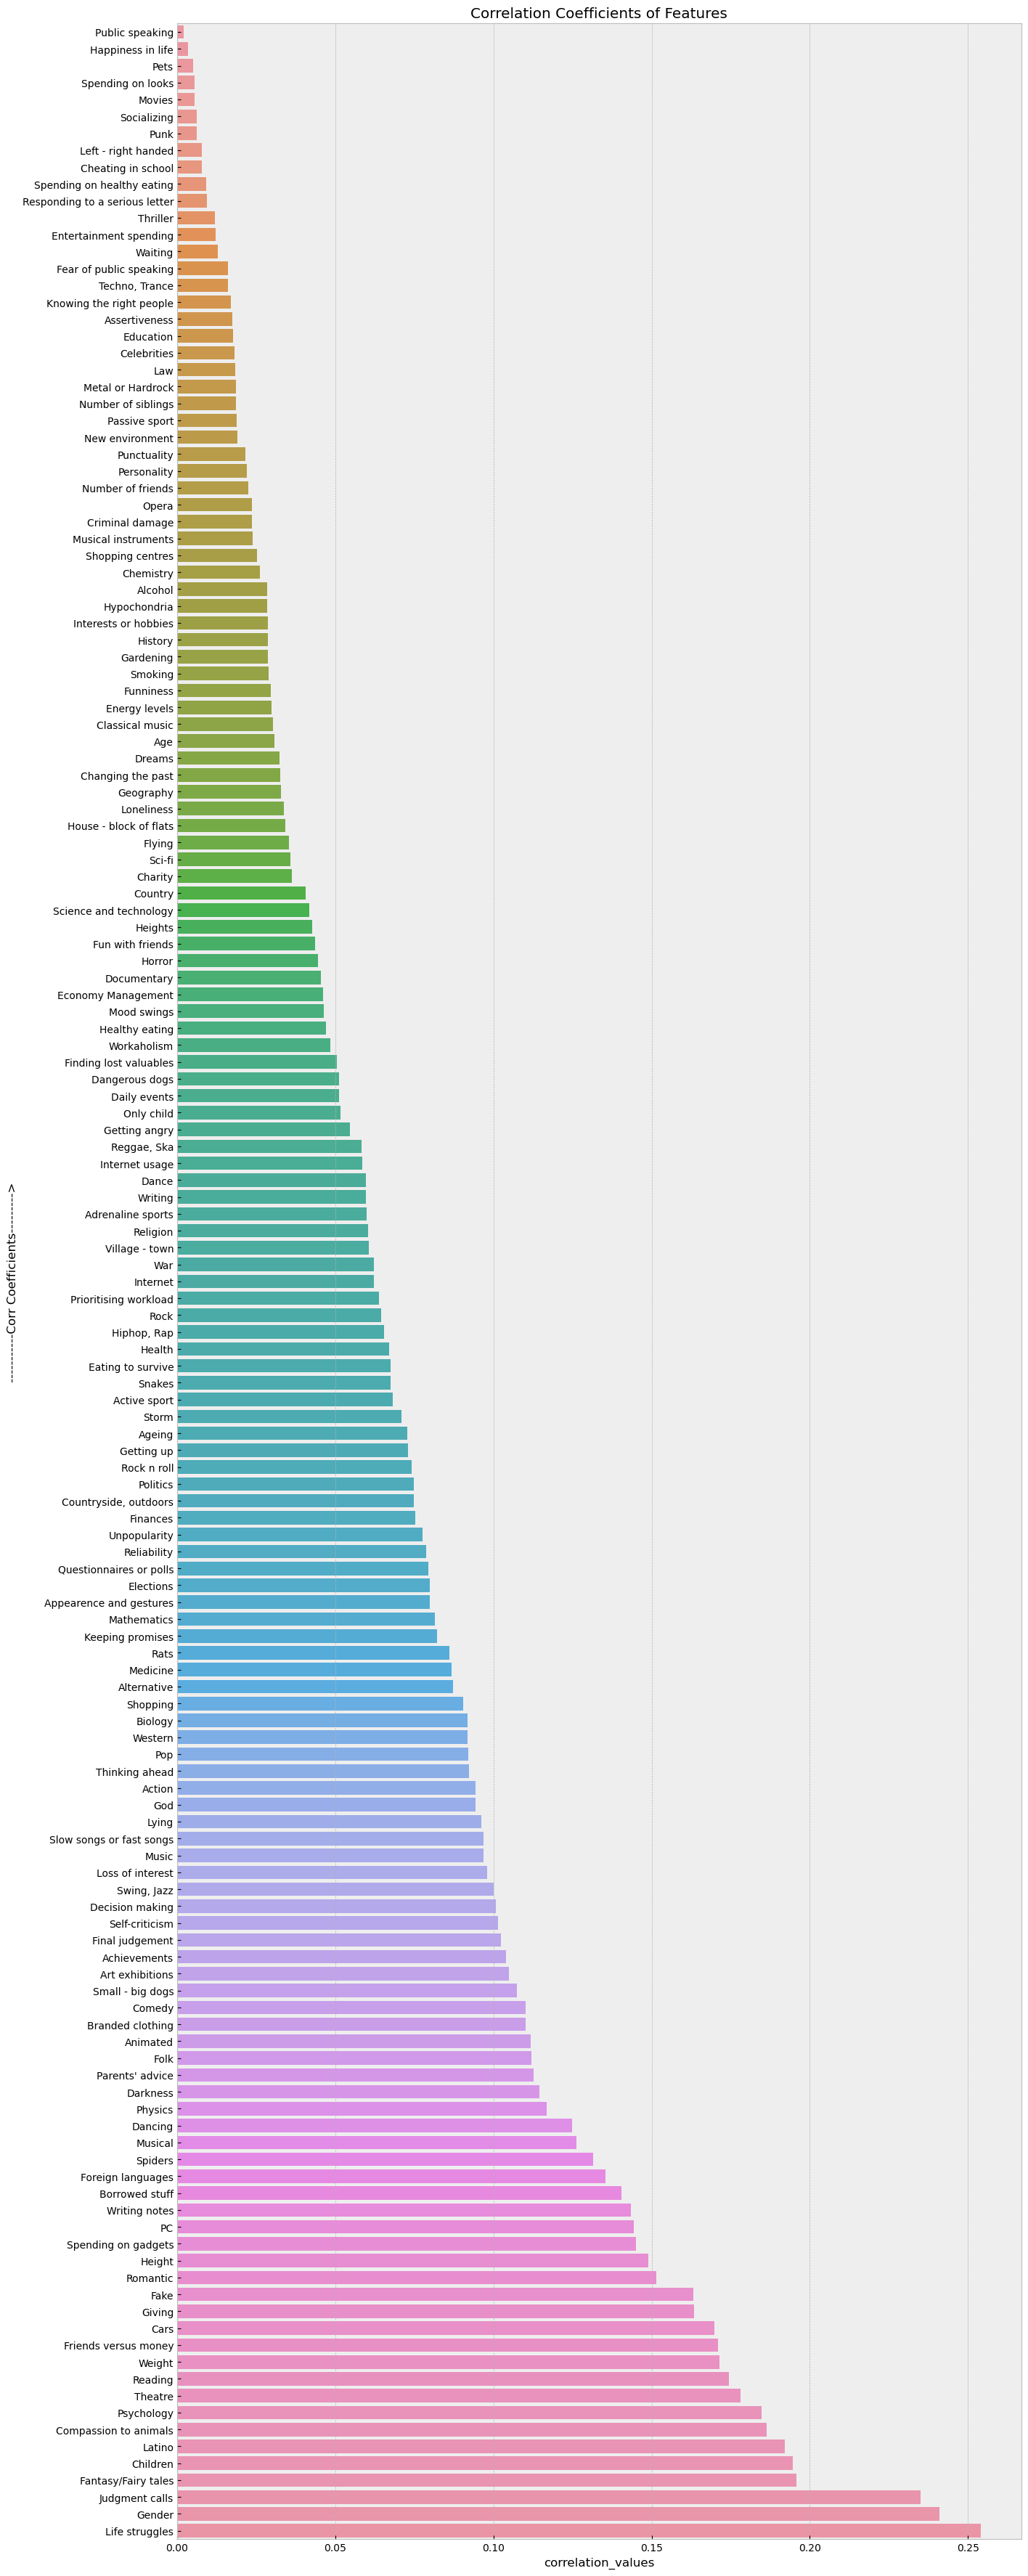

In [58]:
# Plotting the correlations with respect to "Empathy" variable
target = "Empathy"
targetVariable = filledData['Empathy'].to_frame()
corrData = correlationFigure(scaledData, target)
importantFeatures = corrData.sort_values(by="correlation_values", ascending=True).tail(20)

In [59]:
# 20 most important feature with their correlation values
importantFeatures

,features,correlation_values
78,Writing notes,0.143482
47,PC,0.144468
147,Spending on gadgets,0.145000
133,Height,0.148855
23,Romantic,0.151416
87,Fake,0.163273
95,Giving,0.163509
56,Cars,0.169939
85,Friends versus money,0.170961
134,Weight,0.171487


Now, let's join all the important features to make a completely prepared dataset.

In [60]:
finalColumnsList = []
for x in importantFeatures['features']:
    finalColumnsList.append(x)

df = pd.DataFrame() # Final prepared dataset for modelling
df = filledData[finalColumnsList[0]].to_frame()
for x in range(1, len(finalColumnsList)):
    df = df.join(filledData[finalColumnsList[x]].to_frame())

## Model Building 

In [61]:
xTrain, xTest, yTrain, yTest = train_test_split(df, targetVariable, test_size=0.2, random_state=0)
xTrain = xTrain.sort_index()
xTest = xTest.sort_index()
yTrain = yTrain.sort_index()
yTest = yTest.sort_index()

### Decision Tree Model

Hyperparameter Tuning!


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The best parameters for Decision Tree model are :
{'max_depth': 1}

Decision Tree Evaluations :

Training Accuracy => 45.04950495049505
Testing Accuracy => 40.099009900990104

Confusion Matrix => 
[[ 0  0  0  3  4]
 [ 0  0  6 12  3]
 [ 0  0 10 12 16]
 [ 0  0  9 21 37]
 [ 0  0  5 14 50]]

Classification Summary => 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00        21
         3.0       0.33      0.26      0.29        38
         4.0       0.34      0.31      0.33        67
         5.0       0.45      0.72      0.56        69

    accuracy                           0.40       202
   macro avg       0.23      0.26      0.24       202
weighted avg       0.33      0.40      0.35       202




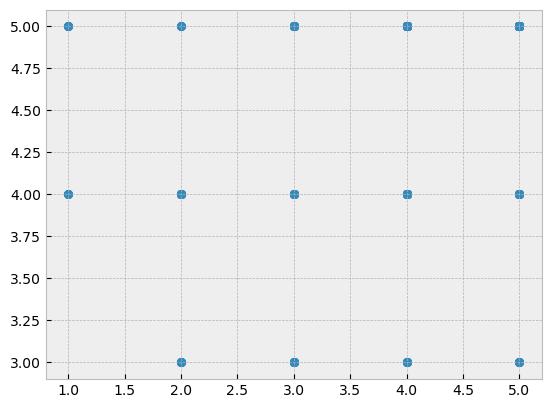

In [62]:
# Decision Tree Modelling
def dt(xTrain, yTrain, xTest, yTest):
    print("Hyperparameter Tuning!")
    gridClassifier = DecisionTreeClassifier()
    depthList = [1,3,5,10]
    parameters = {'max_depth':depthList}
    gridSearch = GridSearchCV(estimator=gridClassifier,
                              param_grid=parameters,
                              scoring="accuracy",
                              cv=10,
                              n_jobs=5)
    gridSearch.fit(xTrain, yTrain.values.ravel())
    bestAccuracyMLP = gridSearch.best_score_
    bestParametersMLP = gridSearch.best_params_

    print("The best parameters for Decision Tree model are :\n{}\n".format(bestParametersMLP))
    dtclassifier = DecisionTreeClassifier(max_depth=3)
    dtclassifier.fit(xTrain, yTrain.values.ravel())
    yPredictiondtTest = dtclassifier.predict(xTest)
    yPredictiondtTrain = dtclassifier.predict(xTrain)
    print("Decision Tree Evaluations :\n")
    print("Training Accuracy => {}".format(accuracy_score(yTrain, yPredictiondtTrain) * 100))
    print("Testing Accuracy => {}\n".format(accuracy_score(yTest, yPredictiondtTest) * 100))
    print("Confusion Matrix => \n{}\n".format(confusion_matrix(yTest, yPredictiondtTest)))
    print("Classification Summary => \n{}\n".format(classification_report(yTest, yPredictiondtTest)))
    plt.scatter(yTest, yPredictiondtTest)

dt(xTrain, yTrain, xTest, yTest)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

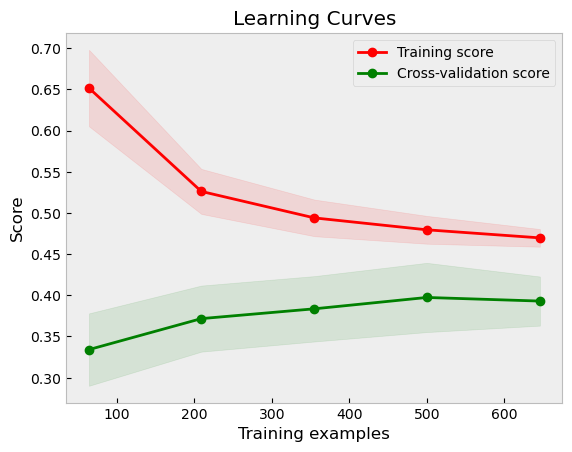

In [63]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# Below function is taken from the official documentation of "sklearn" 
# Link : http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier(max_depth=3)
plot_learning_curve(estimator, title, xTrain, yTrain, cv=cv, n_jobs=4)

### KNN Model

Hyperparameter Tuning!
The best parameters for KNN model are :
{'n_neighbors': 1}

KNN Evaluation :

Training Accuracy => 100.0
Testing Accuracy => 29.207920792079207

Confusion Matrix => 
[[ 0  0  2  3  2]
 [ 0  3 10  5  3]
 [ 2  6 10  7 13]
 [ 2  5  7 19 34]
 [ 1  6 16 19 27]]

Classification Summary => 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.15      0.14      0.15        21
         3.0       0.22      0.26      0.24        38
         4.0       0.36      0.28      0.32        67
         5.0       0.34      0.39      0.36        69

    accuracy                           0.29       202
   macro avg       0.21      0.22      0.21       202
weighted avg       0.29      0.29      0.29       202




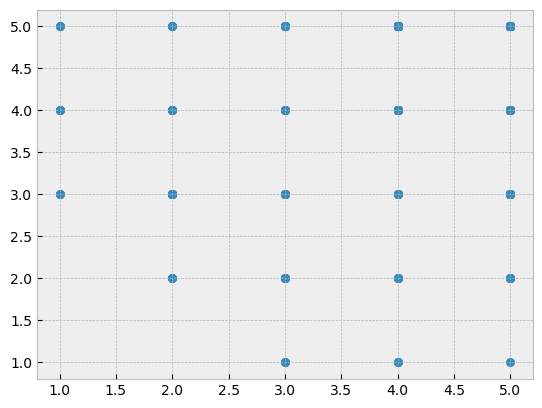

In [64]:
# KNN Modelling
def knn(xTrain, yTrain, xTest, yTest):
    print("Hyperparameter Tuning!")
    gridClassifier = KNeighborsClassifier()
    nearestNeighbors = [1, 3, 5, 10]
    parameters = {'n_neighbors': nearestNeighbors}
    gridSearch = GridSearchCV(estimator=gridClassifier,
                              param_grid=parameters,
                              scoring="accuracy",
                              cv=10,
                              n_jobs=5)
    gridSearch.fit(xTrain, yTrain.values.ravel())
    bestAccuracyMLP = gridSearch.best_score_
    bestParametersMLP = gridSearch.best_params_

    print("The best parameters for KNN model are :\n{}\n".format(bestParametersMLP))
    knnClassifier = KNeighborsClassifier(n_neighbors=1)
    knnClassifier.fit(xTrain, yTrain.values.ravel())
    yPredKNNTest = knnClassifier.predict(xTest)
    yPredKNNTrain = knnClassifier.predict(xTrain)
    print("KNN Evaluation :\n")
    print("Training Accuracy => {}".format(accuracy_score(yTrain, yPredKNNTrain) * 100))
    print("Testing Accuracy => {}\n".format(accuracy_score(yTest, yPredKNNTest) * 100))
    print("Confusion Matrix => \n{}\n".format(confusion_matrix(yTest, yPredKNNTest)))
    print("Classification Summary => \n{}\n".format(classification_report(yTest, yPredKNNTest)))
    plt.scatter(yTest, yPredKNNTest)

knn(xTrain, yTrain, xTest, yTest)

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={n

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

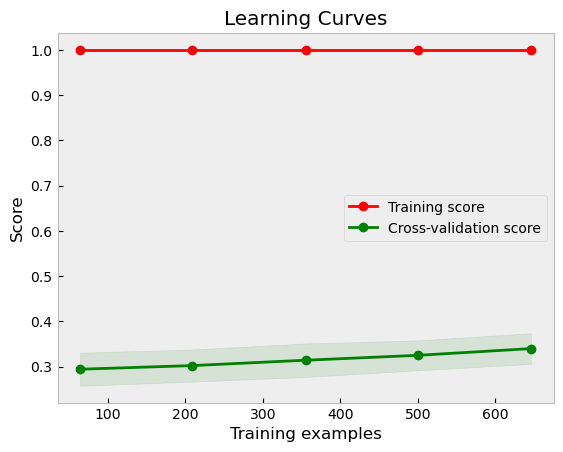

In [65]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# Below function is taken from the official documentation of "sklearn" 
# Link : http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = KNeighborsClassifier(n_neighbors=1)
plot_learning_curve(estimator, title, xTrain, yTrain, cv=cv, n_jobs=4)

### Logistic Regression

Logistic Regression Evaluation :

Testing Accuracy => 39.603960396039604
Confusion Matrix => 
[[ 0  0  0  2  5]
 [ 0  0  8 10  3]
 [ 0  1 10  9 18]
 [ 0  0 13 17 37]
 [ 1  0  6  9 53]]

Classification Summary => 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00        21
         3.0       0.27      0.26      0.27        38
         4.0       0.36      0.25      0.30        67
         5.0       0.46      0.77      0.57        69

    accuracy                           0.40       202
   macro avg       0.22      0.26      0.23       202
weighted avg       0.33      0.40      0.34       202




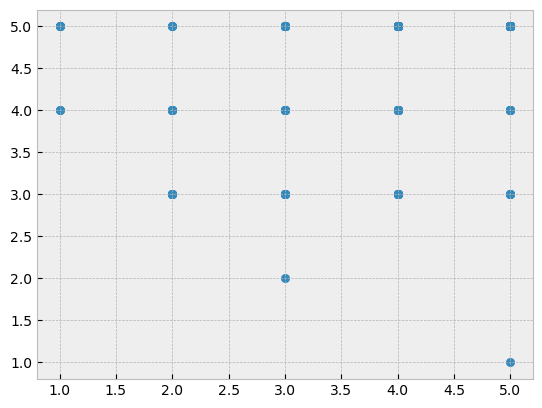

In [66]:
# Logistics Regression Modelling
def logisticRegression(xTrain, yTrain, xTest, yTest):
    logRegClassifier = LogisticRegression(multi_class='ovr', random_state=0, C=3)
    logRegClassifier.fit(xTrain, yTrain.values.ravel())
    yPredLogTest = logRegClassifier.predict(xTest)
    yPredLogTrain = logRegClassifier.predict(xTrain)
    print("Logistic Regression Evaluation :\n")
    print("Testing Accuracy => {}".format(accuracy_score(yTest, yPredLogTest) * 100))
    print("Confusion Matrix => \n{}\n".format(confusion_matrix(yTest, yPredLogTest)))
    print("Classification Summary => \n{}\n".format(classification_report(yTest, yPredLogTest)))
    plt.scatter(yTest, yPredLogTest)


logisticRegression(xTrain, yTrain, xTest, yTest)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

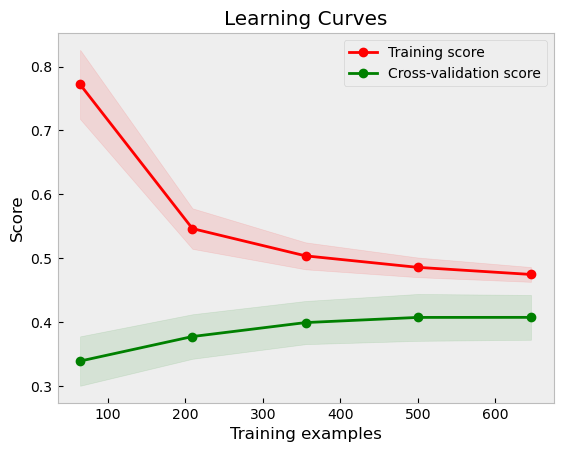

In [67]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# Below function is taken from the official documentation of "sklearn" 
# Link : http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(multi_class='ovr', random_state=0, C=3)
plot_learning_curve(estimator, title, xTrain, yTrain, cv=cv, n_jobs=4)

### Logistic Regression (SelectKBest Feature Method)

Cross Validating for best parameters..
This might take some time..

The best parameters for Logistic Regression model are :
{'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}

Logistic Regression using SelectKBest Method Evaluations :

Training Accuracy : 43.310185185185176
Testing Accuracy  : 41.089108910891085

Confusion Matrix => 
[[ 0  0  0  2  5]
 [ 1  1  6 10  3]
 [ 0  2 10 12 14]
 [ 1  0  9 15 42]
 [ 1  0  5  6 57]]

Classification Summary => 
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.33      0.05      0.08        21
         3.0       0.33      0.26      0.29        38
         4.0       0.33      0.22      0.27        67
         5.0       0.47      0.83      0.60        69

    accuracy                           0.41       202
   macro avg       0.29      0.27      0.25       202
weighted avg       0.37      0.41      0.36       202




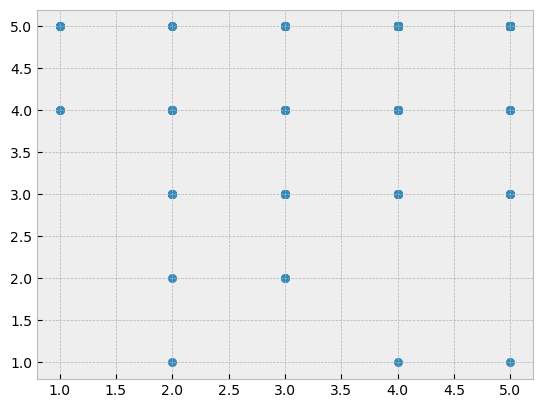

In [68]:
def kBestLogReg(filledData):
    bestDF = filledData.drop(columns=['Empathy'], axis=1)
    targetVariable = filledData['Empathy'].to_frame()
    selected = SelectKBest(score_func=f_classif, k=20)
    selectedFit = selected.fit(bestDF, targetVariable.values.ravel())
    selectedFitTransform = selectedFit.transform(bestDF)

    xTrainBestK, xTestBestK, yTrainBestK, yTestBestK = train_test_split(
        scalingDataset(selectedFitTransform),
        targetVariable,
        test_size=0.2,
        random_state=0)
    print("Cross Validating for best parameters..")
    print("This might take some time..\n")
    lr = LogisticRegression(multi_class='ovr')
    cList = [10, 100, 1000, 10000]
    solverList = ['lbfgs', 'sag', 'saga', 'newton-cg']
    maxIterList = [100, 1000, 10000]
    parameters = {'C': cList, 'solver': solverList, 'max_iter': maxIterList}
    gridSearch = GridSearchCV(estimator=lr,
                              param_grid=parameters,
                              scoring="accuracy",
                              cv=10,
                              n_jobs=4)
    gridSearch.fit(xTrainBestK, yTrainBestK.values.ravel())
    bestAccuracyLogBestK = gridSearch.best_score_
    bestParametersLogBestK = gridSearch.best_params_
    print("The best parameters for Logistic Regression model are :\n{}\n".format(bestParametersLogBestK))
    # Best parameters : C:10, maxiter:100, solver:sag
    lr = LogisticRegression(C=10, max_iter=100, solver='lbfgs', multi_class='ovr', random_state=1)
    lr.fit(xTrainBestK, yTrainBestK.values.ravel())
    yPredLogBestTest = lr.predict(xTestBestK)
    bestKLogAcc = accuracy_score(yTestBestK, yPredLogBestTest)
    print("Logistic Regression using SelectKBest Method Evaluations :\n")
    print("Training Accuracy : {}".format(bestAccuracyLogBestK*100))
    print("Testing Accuracy  : {}\n".format(bestKLogAcc*100))
    print("Confusion Matrix => \n{}\n".format(confusion_matrix(yTestBestK, yPredLogBestTest)))
    print("Classification Summary => \n{}\n".format(classification_report(yTestBestK, yPredLogBestTest)))
    plt.scatter(yTestBestK, yPredLogBestTest)

kBestLogReg(filledData)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

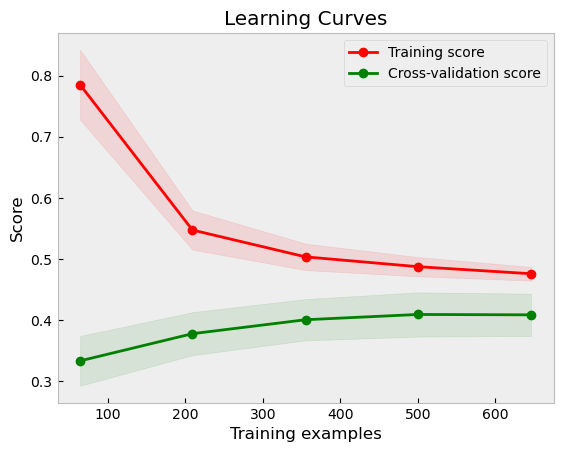

In [69]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# Below function is taken from the official documentation of "sklearn" 
# Link : http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(C=10, max_iter=100, solver='lbfgs', multi_class='ovr', random_state=1)
plot_learning_curve(estimator, title, xTrain, yTrain, cv=cv, n_jobs=4)

### Multilayer Perceptron

Multilayer Perceptron Evaluation :

Testing Accuracy => 71.28712871287128

Confusion Matrix => 
[[ 6  3  3  0  0]
 [ 4 11 14  0  0]
 [ 0  3 27 12  0]
 [ 0  0  8 43  5]
 [ 0  0  1  5 57]]

Classification Summary => 
              precision    recall  f1-score   support

         1.0       0.60      0.50      0.55        12
         2.0       0.65      0.38      0.48        29
         3.0       0.51      0.64      0.57        42
         4.0       0.72      0.77      0.74        56
         5.0       0.92      0.90      0.91        63

    accuracy                           0.71       202
   macro avg       0.68      0.64      0.65       202
weighted avg       0.72      0.71      0.71       202




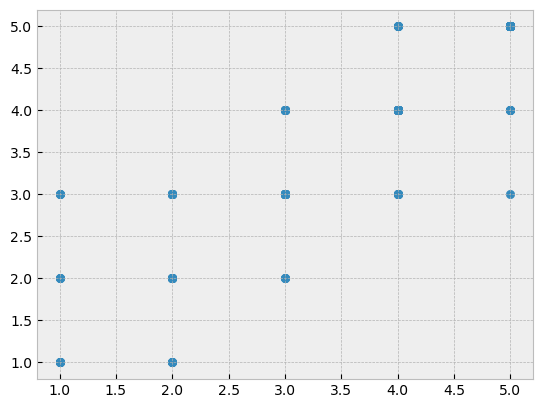

In [70]:
def mlp(df, scaledData, targetVariable):

    # For MLP, we have to use scaled data
    scaledDF = scalingDataset(df)
    xTrain, xTest, yTrain, yTest = train_test_split(scaledData, targetVariable, test_size=0.2, random_state=0, shuffle=False)
    xTrain = xTrain.sort_index()
    xTest = xTest.sort_index()
    yTrain = yTrain.sort_index()
    yTest = yTest.sort_index()
    
    # You can run the below commented code to cross validate for the best parameters
    # print("SIT BACK AND RELAX! CROSS VALIDATION WOULD TAKE SOME TIME...")
    # mlpClass = MLPClassifier(random_state=0)
    # iterList = [100, 500]
    # hiddenLayerList = [(100, 100), (100, 200)]
    # parameters = {'alpha': 10.0 ** -np.arange(1, 7), 'max_iter': iterList, 'hidden_layer_sizes': hiddenLayerList}
    # gridSearch = GridSearchCV(estimator=mlpClass,
    #                           param_grid=parameters,
    #                           scoring="accuracy",
    #                           cv=10,
    #                           n_jobs=10)
    # gridSearch.fit(xTrain, yTrain.values.ravel())
    # bestAccuracyMLP = gridSearch.best_score_
    # bestParametersMLP = gridSearch.best_params_
    # print("The best parameters for MLP model are :\n{}\n".format(bestParametersMLP))

    mlpClass = MLPClassifier(hidden_layer_sizes=(100, 200), alpha=0.1, max_iter=500, random_state=0)
    mlpClass.fit(xTrain, yTrain.values.ravel())
    yPredMLP = mlpClass.predict(xTest)
    print("Multilayer Perceptron Evaluation :\n")
    # print("Training Accuracy => {}".format(bestAccuracyMLP*100))
    print("Testing Accuracy => {}\n".format(accuracy_score(yTest, yPredMLP)*100))
    print("Confusion Matrix => \n{}\n".format(confusion_matrix(yTest, yPredMLP)))
    print("Classification Summary => \n{}\n".format(classification_report(yTest, yPredMLP)))
    plt.scatter(yTest, yPredMLP)

mlp(df, scaledData, targetVariable)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed w

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

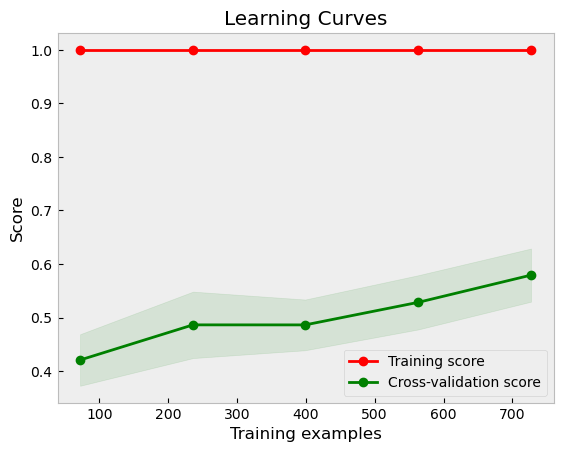

In [71]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# Below function is taken from the official documentation of "sklearn" 
# Link : http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=10,
                        n_jobs=10, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
xTrain, xTest, yTrain, yTest = train_test_split(scaledData, targetVariable, test_size=0.2, random_state=0, shuffle=False)
xTrain = xTrain.sort_index()
xTest = xTest.sort_index()
yTrain = yTrain.sort_index()
yTest = yTest.sort_index()

estimator = MLPClassifier(hidden_layer_sizes=(100, 200), alpha=0.1, max_iter=500)
plot_learning_curve(estimator, title, xTrain, yTrain, cv=10, n_jobs=10)